In [1]:
### Import required packages

#system packages
import os   # operating system library
import odbc # for open database connectivity connections
import gc   # garbage collector

#data science packages
import pandas as pd  # best for working with dataframes
import numpy as np
from matplotlib import pyplot

import itertools
from scipy.spatial import distance_matrix
from operator import itemgetter

### Set Parameters

#change the folder we're working with
os.chdir('C:\Users\us44532\Documents\Python Scripts')

chunkSize = 50000
states = ['WA'] # to be updated with more states and to be looped through in _main_

### Connect to Netezza

cnxn = odbc.odbc('DSN=CUE') # depends on your named connections in your ODBC Manager



# FACTOR = 0.3

In [2]:
# set Header Query
def setHDRSQL(state, cursor, chunkSize):
    sqlHDRString = """
    SELECT   CITY
           , ZIP_CODE
           , LONGITUDE
           , LATITUDE
      FROM IDS_LAB..ZIP_LAT_LONGS
     WHERE
         STATE_CD = '{}'
         AND ZIP_CODE > {}
     LIMIT {}""".format(state, str(cursor), chunkSize)
    return sqlHDRString

In [3]:
def readStateZips(state):
    cursor = 0
    chunkID = 1
    continueQuery = True
    first = True
    while continueQuery:
        try:
            sqlHDRString = setHDRSQL(state, cursor, chunkSize)
            #print (sqlHDRString)
            tempDf = pd.read_sql(sqlHDRString,cnxn)
            continueQuery = tempDf.shape[0]>0
            cursor = tempDf.ZIP_CODE.max()
            if first:
                df = tempDf
                first = False
            else:
                df.append(tempDf)
                tempDf = None
            return df
        except:
            print ('error in read_sql')
            continueQuery = False
            return None

In [4]:
def normalize(arr):
    arr = arr+(np.random.randn(len(arr))-0.5)/10000
    return arr #(arr-arr.min())/(arr.max()-arr.min())

In [5]:
try:
    # read directly from the flat file if it exists in our directory
    df = pd.read_csv('raw_zip_codes.csv')
    df.drop([df.columns[0]], axis = 1, inplace = True)
    print('Read from .csv')
except:
    # otherwise execute a SQL script and read from the database    
    state = states[0]
    df = readStateZips(state)
    print('Read from database')
df = pd.DataFrame(zip(df.CITY,df.ZIP_CODE,df.LONGITUDE, df.LATITUDE))
df.columns = (['CITY','ZIP_CODE','LONGITUDE','LATITUDE'])

Read from .csv


In [6]:
e = np.array(zip(df.CITY #cityEncode.transform(df.CITY)
                 , df.ZIP_CODE #zipEncode.transform(df.ZIP_CODE)
                 , normalize(df.LONGITUDE)
                 , normalize(df.LATITUDE)
                ))
# %matplotlib inline
e

array([['Snoqualmie', '98065', '-121.830596622', '47.5304995217'],
       ['Raymond', '98577', '-123.677000324', '46.668610739'],
       ['Olympia', '98506', '-122.872373097', '47.0693568057'],
       ..., 
       ['Spokane', '99210', '-117.431571803', '47.6534023688'],
       ['Cle Elum', '98922', '-120.917364348', '47.1937273693'],
       ['Kennewick', '99536', '-119.160386621', '46.2167444749']], 
      dtype='|S24')

## Define Functions

In [7]:
class GeoHex(object):
    """ A GeoHex is a unit mapping spatial coordinates (primarily in longitude/latitude terms)
    to a Hexagonal grid while carrying a set of hierarchical properties 
    
    Attributes:
        hierarchy of categorical variables (such as country, state, county, city, zip_code)
        longitude, latitude: float coordinates
        distance from some point in long/lat space 
        x, y coordinates in hex-grid space 
        vacant: boolvacancy (a GeoHex might be initialized as empty)
        placement order
        """
    neighbors = set([(4,0),(2,3),(-2,3),(-4,0),(-2,-3),(2,-3)]) # shared class variable 
    
    def __init__(self, limbo = True, vacant_grid = True, name = ''):
        self.name = name
        self.hier = []
        self.position = (None, None) # initializes nowhere with limbo being True
        self.vacant_grid = vacant_grid
        self.grid_xy = (None, None) # initializes vacant
        self.limbo = limbo
        self.local_neighbors = set() # set of tuples
        self.cursor_distance = None
        """Return a GeoHex object """
        
    def __repr__(self):
        return str(self.__dict__)
        
    def add_hier(self, hierarchy):
        for h in hierarchy:
            self.hier.append(h)
            
    def set_position(self, position):
        self.position = position
        self.limbo = False
        if self.grid_xy != (None, None):
            vacant_grid = False
    
    def set_grid(self, grid_xy):
        self.grid_xy = grid_xy
        self.vacant_grid = False
        if self.position != (None, None):
            limbo = False
        self.local_neighbors = set({(self.grid_xy[0] + neighbor[0], 
                                     self.grid_xy[1] + neighbor[1]) 
                                    for neighbor in GeoHex.neighbors})

In [10]:
class HexNeighborhood(object):
    """ A HexNeighborhood object is a collection of GeoHex objects organized in a hexagonal grid
    
    Attributes:
        name:    name of the neighborhood
        hex_count:    the number of placed hexagons in the neighborhood
        map_center:    the weighted average lat/long of the placed hexagons
        hex_center:    the weighted average of the placed hex coordinates
        placed:   set of placed hexagons (GeoHex objects)
        unplaced:   set of unplaced hexagons (GeoHex objects)
        available_neighbors:   set of available neighbors (tuples of x, y coordinates)
        stop_loop:   an internal status flag for debugging loops
        position_array:   a distance matrix used to measure density (how to know where to start placement)
    
    Global Attributes:
        factor: a multiplier used to tune the relationship between lat/long distance and hex grid distance
        epsilon: a positive non-zero potentially helpful in avoiding div/0 errors
        
    Methods:
        
     """
    factor = 0.3
    epsilon = 0.005
    
    def __init__(self, name):
        self.name = name
        self.hex_count = 0
        self.map_center = (0.0,0.0)
        self.hex_center = (0.0,0.0)
        self.placed = set() #set of GeoHex objects
        self.unplaced = set() #set of GeoHex objects
        self.available_neighbors = set() #set of tuples
        self.stop_loop = False
        self.position_array = np.empty(0)
    
#     def __repr__(self):
# #         print(self.__dict__)
#         pass
        
    def add(self, geohex):
#         if not geohex.limbo:
#             self.map_center = tuple([(self.hex_count * self.map_center[i] + geohex.position[i])
#                                      / (self.hex_count + 1) for i in range(2)])
#         if not geohex.vacant_grid:
#             self.hex_center = tuple([(self.hex_count * self.map_center[i] + geohex.grid_xy[i])
#                                      / (self.hex_count + 1) for i in range(2)])
#         self.hex_count += 1
        self.unplaced.add(geohex)
    
    def set_dist_matrix(self): # the distance matrix is used to measure density
        self.position_array = np.vstack({node.position for node in self.unplaced})
        self.dist_matrix = distance_matrix(self.position_array, self.position_array) # distance_matrix is imported from scipy.spatial
        return self.dist_matrix
    
    @staticmethod
    def inv_sum(row, epsilon = 0.005): 
        return np.mean([1/(x+epsilon) for x in row])
        
    def start_node(self, epsilon = 0.005):
        try:
            density = np.apply_along_axis(HexNeighborhood.inv_sum, 0, self.dist_matrix, epsilon = 0.04)
            highest = self.position_array[np.argmax(density)]
            return [geohex for geohex in self.unplaced if geohex.position == (highest[0], highest[1])][0]
        except:
            if not self.stop_loop:
                self.set_dist_matrix()
                self.stop_loop = True
                return self.start_node()
            else:
                return None
            
    def update_available_neighbors(self, geohex):
        new_neighbors = geohex.local_neighbors
        for neighbor in new_neighbors:
            self.available_neighbors.add(neighbor)
        for preplaced in new_neighbors.intersection(set(node.grid_xy for node in self.placed)):
            self.available_neighbors.remove(preplaced)
        return self.available_neighbors
        
    def set_start(self): # run once after nodes are loaded into unplaced set
        start_node = self.start_node()
        start_node.set_grid((0,0))
        start_node.cursor_distance = 0.0
        self.map_center = start_node.position
        self.placed.add(start_node)
        self.unplaced.remove(start_node)
        self.hex_count += 1
        return start_node
    
    def min_node(self, cursor_hier):
        x = 1e10
        outnode = None
        for node in self.unplaced:
            if node.cursor_distance < x and np.all(node.hier[i]==cursor_hier[i] for i in range(len(cursor_hier))):
                x = node.cursor_distance
                outnode = node
        return outnode
    
    def squared_distances_to_geo_center(self, hier):
        counter = 0
        for node in self.unplaced: 
            if np.all([node.hier[i] == hier[i] for i in range(len(hier))]):
                node.cursor_distance = HexNeighborhood.squared_distance(self.map_center, node.position)
                counter += 1
        sorted(self.unplaced, key = self.dist)
        return counter
        
    def get_close_hex(self, geohex):
        hex_space = [4*(geohex.position[i] - self.map_center[i])
                     /(HexNeighborhood.epsilon + np.sqrt(geohex.cursor_distance/self.hex_count)) 
                     for i in range(2)]
        return min([(node, HexNeighborhood.squared_distance(node, hex_space))
                    for node in self.available_neighbors], key = itemgetter(1))#[1][1:]
    
    @staticmethod
    def squared_distance(node1, node2):
        return sum([(node1[i]-node2[i])**2 for i in range(len(node1))])
    
    def dist(self, x):
        yield [node.cursor_distance for node in self.unplaced]
        
    def place(self, geohex):
#         print self.available_neighbors
        geohex.set_grid(self.get_close_hex(geohex)[0])
        self.placed.add(next_place)
        self.unplaced.remove(next_place)
        self.update_available_neighbors(geohex) 
        self.hex_count += 1
        self.map_center = tuple([(self.hex_count * self.map_center[i] + geohex.position[i])
                                / (self.hex_count + 1.0) for i in range(2)])
        self.hex_center = tuple([(self.hex_count * self.hex_center[i] + np.float(geohex.grid_xy[i]))
                                / (self.hex_count + 1.0) for i in range(2)])
#         print self.available_neighbors
# f =np.vstack({tuple(row) for row in data}) # gets unique rows
# # e.shape, f.shape
# a = dm(f,f)

# density = np.apply_along_axis(invSum,0,a, epsilon = 0.04)
# highest = f[np.argmax(density)]
# top = e[np.logical_and(e[:,2]==highest[0], e[:,3]==highest[1])]

#         if not geohex.limbo:
#             self.map_center = tuple([(self.hex_count * self.map_center[i] + geohex.position[i])
#                                      / (self.hex_count + 1) for i in range(2)])
#         if not geohex.vacant_grid:
#             self.hex_center = tuple([(self.hex_count * self.map_center[i] + geohex.grid_xy[i])
#                                      / (self.hex_count + 1) for i in range(2)])

In [12]:
test_neighborhood = HexNeighborhood('Washington Zip Codes')
for i in range(len(e)):
    test = GeoHex(name = e[i][1])
    test.set_position((np.float(e[i][2]),np.float(e[i][3])))
    test.add_hier(e[i][:1])
    test_neighborhood.add(test)
# test_neighborhood.set_dist_matrix()
start_node = test_neighborhood.set_start()
start_node.set_grid((0,0))
test_neighborhood.update_available_neighbors(start_node)
#, [node.__dict__ for node in test_neighborhood.unplaced]
cursor_hier = start_node.hier
for i in range(10):
    distance_count = test_neighborhood.squared_distances_to_geo_center(cursor_hier)
    loop_counter = 0
    while distance_count == 0 and loop_counter < 5:
        cursor_hier = cursor_hier[:-1]
        distance_count = test_neighborhood.squared_distances_to_geo_center(cursor_hier)
        loop_counter += 1
    next_place = test_neighborhood.min_node(cursor_hier)
    test_neighborhood.place(next_place)
    cursor_hier = next_place.hier
test_neighborhood.__dict__

# .__dict__, loop_counter

TypeError: unsupported operand type(s) for /: 'NoneType' and 'int'

In [83]:

def distancesToCenter(center, unplaced):
    return [(center[0]-node[0])**2 + (center[1]-node[1])**2 for node in unplaced]

def updateDistances(center, unplaced):
    return set(sorted(distancesToCenterPlus(center,unplaced), key = lambda x: x[0]))
def newCenter(center, nextPlace):
     return ((len(placed)*center[0]+nextPlace[1])/(len(placed)+1)
             ,(len(placed)*center[1]+nextPlace[2])/(len(placed)+1))
def getCloseHex(nextPlace, center, availableNeighbors):
    return min([a for a in enumerate(distancesToCenterPlus((nextPlace[1],nextPlace[2])
                                            ,[(np.sqrt(nextPlace[0])*float(x)/4/FACTOR+center[0]
                                               ,np.sqrt(nextPlace[0])*float(y)/4/FACTOR+center[1])
                                              for (x,y) in availableNeighbors]))]
               , key = itemgetter(1))[1][1:]
def newNeighbors(xh,yh):
    return set([(x+xh, y+yh) for x, y in neighbors])
def moveNeighborhood(availableNeighbors, placedGrid, xh, yh):
    for x in newNeighbors(xh, yh):
        availableNeighbors.add(x)
    for p in placedGrid.intersection(availableNeighbors):
        availableNeighbors.remove(p)
    return availableNeighbors
def getHexCoordinates(closeHex, center, nextPlace):
    x, y = 4*FACTOR*(closeHex[0]-center[0])/np.sqrt(nextPlace[0]), 4*FACTOR*(closeHex[1]-center[1])/np.sqrt(nextPlace[0])
    return int(np.round(x)), int(np.round(y))

def plotUnplaced(s):
    arr = np.array([[t[1], t[2]] for t in s])
    pyplot.scatter(arr[:,0], arr[:,1])
    #Look, a map of Washington!
def plotPlaced(s):
    arrXy = np.array([[t[0][0],t[0][1]] for t in s])
    pyplot.scatter(arrXy[:,0],arrXy[:,1])
    #Look, a scatter map of placed in Washington!
def plotHexPlaced(s):
    x, y = [t[1][0] for t in s], [t[1][1] for t in s]
    pyplot.scatter(x, y)
    #Look, a scatter map of placed in Washington!

In [84]:
center = tuple(highest)
startRow = 0
startSlash = 0
unplaced = set(sorted(distancesToCenterPlus(center,f), key = lambda x: x[0]))
unplaced.remove(min(unplaced))
#initialize placed
placed = set([tuple((tuple(highest),tuple((int(startRow),int(startSlash)))))])
neighbors = set([(4,0),(2,3),(-2,3),(-4,0),(-2,-3),(2,-3)])
availableNeighbors = neighbors.copy()
# fullNeighborhood = set()
placed, availableNeighbors, center, [val for val in itertools.islice(sorted(unplaced),6)]

({((-121.80342419934233, 47.432189725973743), (0, 0))},
 {(-4, 0), (-2, -3), (-2, 3), (2, -3), (2, 3), (4, 0)},
 (-121.80342419934233, 47.432189725973743),
 [(2.1366402580305178e-09, -121.80338856847727, 47.432219172225004),
  (2.2371031563006176e-09, -121.80346948223314, 47.432176067168662),
  (2.3575795201872054e-09, -121.80343791239757, 47.432143147742387),
  (3.2300411128376807e-09, -121.80346461839282, 47.432149771731538),
  (3.4932046297028879e-09, -121.80339940697513, 47.43213607391732),
  (3.9990651613005602e-09, -121.80337157345349, 47.432224791355317)])

In [85]:
# we begin with newNode closest to center
nextPlace = min(unplaced)
unplaced.remove(nextPlace)
center = newCenter(center, nextPlace)
# update distances with updated center of mass
unplaced = updateDistances(center, unplaced)
nextPlace, center, unplaced

((2.1366402580305178e-09, -121.80338856847727, 47.432219172225004),
 (-121.8034063839098, 47.432204449099373),
 {(1.6255752456017039e-09, -121.80337157345349, 47.432224791355317),
  (3.1019875533429181e-09, -121.80343422458076, 47.432252686891552),
  (3.5417275102492293e-09, -121.80334746627391, 47.432196056263706),
  (3.9856210347106955e-09, -121.80336388297684, 47.43225113198416),
  (4.2781731283060222e-09, -121.80334724453377, 47.432176507958907),
  (4.7238431382045776e-09, -121.80339940697513, 47.43213607391732),
  (4.751901909227478e-09, -121.80343791239757, 47.432143147742387),
  (4.7869323989543892e-09, -121.80346948223314, 47.432176067168662),
  (5.9827012194371293e-09, -121.8033351194601, 47.432234517012972),
  (6.0579955870934519e-09, -121.80339292394319, 47.432281109551276),
  (6.2076387864338499e-09, -121.8034751631521, 47.432242881567618),
  (6.3808695660653827e-09, -121.80346461839282, 47.432149771731538),
  (6.7413218146631443e-09, -121.80332481181176, 47.432213793329467

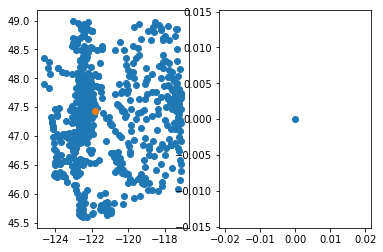

In [86]:
# updateDistances(center,unplaced)
pyplot.subplot(1,2,1)
plotUnplaced(unplaced)
plotPlaced(placed)
pyplot.subplot(1,2,2)
plotHexPlaced(placed)

In [87]:
closestPlacedHex = min(updateDistances(nextPlace[-2:],[p[0] for p in placed]))
cphGrid = [p[1] for p in placed if (p[0][0] == closestPlacedHex[1] 
                                    and p[0][1] == closestPlacedHex[2])][0]


cphGrid, closestPlacedHex

((0, 0), (2.1366402580305178e-09, -121.80342419934233, 47.432189725973743))

In [88]:
translatedNeighbors = set({(a[0]-cphGrid[0], a[1]-cphGrid[1]) for a in availableNeighbors})
cphGrid, translatedNeighbors

((0, 0), {(-4, 0), (-2, -3), (-2, 3), (2, -3), (2, 3), (4, 0)})

In [89]:
closestNeighborHex = getCloseHex(nextPlace, closestPlacedHex[-2:], translatedNeighbors)
closestPlacedHex, closestNeighborHex, translatedNeighbors

((2.1366402580305178e-09, -121.80342419934233, 47.432189725973743),
 (-121.80334715966536, 47.4323052854892),
 {(-4, 0), (-2, -3), (-2, 3), (2, -3), (2, 3), (4, 0)})

In [90]:
xh, yh = getHexCoordinates(closestNeighborHex, closestPlacedHex[-2:], nextPlace)
placed.add(((nextPlace[1],nextPlace[2]),(xh + cphGrid[0], yh + cphGrid[1])))
placedGrid = set([x[1] for x in placed])
availableNeighbors = moveNeighborhood(availableNeighbors, placedGrid, xh + cphGrid[0], yh + cphGrid[1])
xh, yh, availableNeighbors, placed, placedGrid

# find closest hex among placed not in fullNeighborhood
# find available neighbor hexes to closeHex

# find neighborHex closest to newNode

# place newNode in neighborHex

# update availableNeighbors

# find newNode closest to center

(2,
 3,
 {(-4, 0), (-2, -3), (-2, 3), (0, 6), (2, -3), (4, 0), (4, 6), (6, 3)},
 {((-121.80342419934233, 47.432189725973743), (0, 0)),
  ((-121.80338856847727, 47.432219172225004), (2, 3))},
 {(0, 0), (2, 3)})

In [91]:
# def assignNewHex():
for i in range(753):
    # we begin with newNode closest to center
    nextPlace = min(unplaced)
    unplaced.remove(nextPlace)
    center = newCenter(center, nextPlace)
    # update distances with updated center of mass
    unplaced = updateDistances(center, unplaced)
    # now on to placing our new hex
    
    closestPlacedHex = min(updateDistances(nextPlace[-2:],[p[0] for p in placed]))
    cphGrid = [p[1] for p in placed if (p[0][0] == closestPlacedHex[1] 
                                        and p[0][1] == closestPlacedHex[2])][0]
    translatedNeighbors = set({(a[0]-cphGrid[0], a[1]-cphGrid[1]) for a in availableNeighbors})
    closestNeighborHex = getCloseHex(nextPlace, closestPlacedHex[-2:], translatedNeighbors)

    xh, yh = getHexCoordinates(closestNeighborHex, closestPlacedHex[-2:], nextPlace)
    placed.add(((nextPlace[1],nextPlace[2]),(xh + cphGrid[0], yh + cphGrid[1])))
    placedGrid = set([x[1] for x in placed])
    availableNeighbors = moveNeighborhood(availableNeighbors, placedGrid, xh + cphGrid[0], yh + cphGrid[1])

    

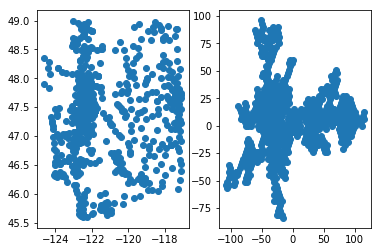

In [94]:
pyplot.subplot(1,2,1)
try:
    plotUnplaced(unplaced)
except:
    pass
try:
    plotPlaced(placed)
except:
    pass
pyplot.subplot(1,2,2)
try:
    plotHexPlaced(placed)
except:
    pass

In [95]:
outArray = [[i[0], i[1], i[2], i[3], p[1][0], p[1][1]] for i in e for p in placed if (i[2],i[3]) == p[0]]

In [10]:
pd.DataFrame([[zipEncode.inverse_transform(int(i[0]))
              , cityEncode.inverse_transform(int(i[1]))
              , i[4],i[5]] for i in outArray]
            , columns = ['zip', 'city', 'x', 'y']).to_csv('mapped_hexes.csv')

NameError: name 'outArray' is not defined

In [11]:
df[['ZIP_CODE','CITY', 'LONGITUDE', 'LATITUDE']].to_csv('raw_zip_codes.csv')